<a href="https://colab.research.google.com/github/peeyushsinghal/DA-CV/blob/main/sfew_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps
1. Libraries
2. Dataset - read | create | show example
3. Dataloader - show example
4. Transforms - Normalize
5. Model - summary, pre-trained
6. Train Function
7. Test Function
8. Training - One Cycle LR

In [ ]:
# !pip install torchsummary
!pip install torch-summary



In [ ]:
# importing libraries
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from torchsummary import summary
from torchvision.datasets import ImageFolder # for datasets (reference: Sai's usage)
from torch.utils.data import DataLoader, Dataset
import os
import zipfile

In [ ]:
torch.__version__

'2.0.1+cu118'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset
We are using SFEW dataset, which contains `['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']` classes

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/sfew'
EXTRACT_BASE_PATH = '/content/sample_data'
EXTRACT_DIR = os.path.join(EXTRACT_BASE_PATH,'sfew')
if not os.path.exists(EXTRACT_DIR):
  # create directory
  os.makedirs(EXTRACT_DIR)
  print(f'Directory {EXTRACT_DIR} created successfully.')
else:
    print(f'Directory {EXTRACT_DIR} already exists.')

Directory /content/sample_data/sfew created successfully.


In [ ]:
# extracting data into EXTRACT_DIR
# Open the zip file
ZIP_FILE_PATH = os.path.join(BASE_PATH,'SFEW_2.zip')
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    # printing all the contents of the zip file
    zip_ref.printdir()
    # Extract all files to the specified directory
    zip_ref.extractall(EXTRACT_DIR)
print("File extraction complete.")

File Name                                             Modified             Size
Test/SFEW_2_Test.zip                           2015-07-08 14:11:20    199060703
Test/Test_Aligned_Faces.zip                    2015-07-08 12:20:40     11029890
Test/Test_Aligned_Points.zip                   2015-07-08 12:55:12       248998
Test/Test_LPQ_Features.zip                     2015-07-08 12:22:44       467744
Test/Test_PHOG_Features.zip                    2015-07-08 12:19:32      7259705
Train/Angry.zip                                2015-05-17 00:14:22     96754962
Train/Disgust.zip                              2015-05-17 12:41:38     32233965
Train/Fear.zip                                 2015-05-17 13:06:54     41873696
Train/Happy.zip                                2016-10-12 17:15:44    119766884
Train/Neutral.zip                              2015-05-17 02:07:38     82149409
Train/Sad.zip                                  2015-05-17 12:25:48    101196826
Train/Surprise.zip                      

In [ ]:
labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [ ]:
# finding directories after unzip in EXTRACT_DIR
print(os.listdir(EXTRACT_DIR))
dict_dataset = {'TRAIN_DIR' : os.path.join(EXTRACT_DIR,'Train'),
                'TEST_DIR' : os.path.join(EXTRACT_DIR,'Test'),
                'VAL_DIR' : os.path.join(EXTRACT_DIR,'Val')}

for dir_name, dir in dict_dataset.items():
  for zips in os.listdir(dir):
    temp_file_name = (zips).split(".")[0]
    if temp_file_name in labels:
      print (dir, zips, temp_file_name)
      with zipfile.ZipFile(os.path.join(dir,zips), 'r') as zip_ref:
        zip_ref.extractall(dir)
        print(f'...completed for {dir}/{zip}')


['Val', 'Test', 'Train']
/content/sample_data/sfew/Train Disgust.zip Disgust
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Surprise.zip Surprise
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Neutral.zip Neutral
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Fear.zip Fear
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Angry.zip Angry
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Happy.zip Happy
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Train Sad.zip Sad
...completed for /content/sample_data/sfew/Train/<class 'zip'>
/content/sample_data/sfew/Val Disgust.zip Disgust
...completed for /content/sample_data/sfew/Val/<class 'zip'>
/content/sample_data/sfew/Val Surprise.zip Surprise
...completed for /content/s

In [ ]:
## creating a dataset without transforms to understand mean and std deviation.
train_ds = ImageFolder(root=dict_dataset['TRAIN_DIR'],
                       transform=transforms.ToTensor())
print(f'Number of images in train_ds: {len(train_ds)}')

Number of images in train_ds: 958


In [ ]:
def get_mean_std_dev(dataset):
  '''
  get mean and std deviation of dataset
  '''
  loader = DataLoader(dataset,
                      batch_size = 1,
                      num_workers=1,
                      shuffle = False)
  mean, std, num_samples = 0.0, 0.0, 0.0
  for images, _ in loader:
    batch_size = images.size(0)
    images = images.view(batch_size, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    num_samples += batch_size

  mean /= num_samples
  std /= num_samples
  print("Mean:", mean)
  print("Standard Deviation:", std)
  return tuple(mean.numpy()), tuple(std.numpy())

In [ ]:
mean_ds, std_dev_ds = get_mean_std_dev(train_ds)

Mean: tensor([0.2197, 0.1858, 0.1569])
Standard Deviation: tensor([0.1810, 0.1635, 0.1511])


In [ ]:
# Train Phase transformations
#TODO: Use albumentations in later versions
train_transforms = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                      #  transforms.RandomCrop(224, padding=10, padding_mode='reflect'),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomRotation(5),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean_ds, std_dev_ds)
                                       ])

# Val Phase transformations
val_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean_ds, std_dev_ds)
                                     ])

In [ ]:
# dataset
train_ds = ImageFolder(root=dict_dataset['TRAIN_DIR'],
                       transform=train_transforms)
val_ds = ImageFolder(root=dict_dataset['VAL_DIR'],
                       transform=val_transforms)

In [ ]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
BATCH_SIZE = 8
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = DataLoader(train_ds, **dataloader_args)

# test dataloader
val_loader = DataLoader(val_ds, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # functions to show an image


# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # get some random training images
# dataiter = iter(train_loader)
# images, emotions = next(dataiter)

# imshow(torchvision.utils.make_grid(images[:4]))
# # print labels
# print(' '.join(f'{labels[emotions[j].item()]:20s}' for j in range(4)))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(dataset_loader,label_names,num_images=5):
  '''
  shows a batch of images (default = 5)
  '''
  images, targets = next(iter(dataset_loader))
  plt.figure(figsize=(16, 8))
  for i in range(num_images):
    ax = plt.subplot(int(num_images//5)+1, 5, i + 1)
    images[i] = images[i] / 2 + 0.5 # unnormalize
    ax.imshow(images[i].permute(1, 2, 0))
    plt.title(label_names[targets[i]])
    plt.axis("off")

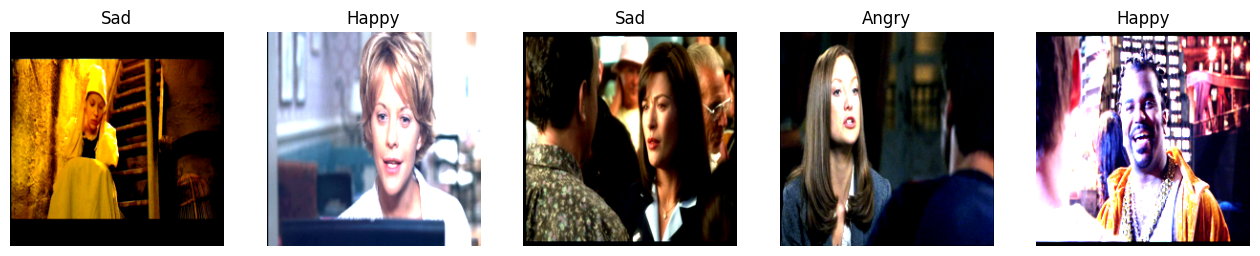

In [ ]:
show_batch(train_loader,labels,5)

## Model

In [ ]:
# Load pretrained resnet50 (reference: https://pytorch.org/vision/main/models.html )
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device) # original model
# summary of the model
summary(model, input_size=(3, 224, 224), depth = 3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 305MB/s]


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  16,384
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 16,384
|    |    └─BatchNorm2d: 3-14      

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  16,384
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 16,384
|    |    └─BatchNorm2d: 3-14      

In [ ]:
# printing model to check the last FC layer
model #  (fc): Linear(in_features=2048, out_features=1000, bias=True)
#TODO: replace ReLU with nn.Identity for last layer.
#TODO: how to remove BN in the last layer??

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# changing the model FC layer, so that it has got 2048 as input, but output may be num_classes
# labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'], so 7

# num_classes = len(labels)

model.fc = nn.Sequential(
    nn.Linear(in_features=2048,out_features=256),
    nn.ReLU(inplace=True), # as per other ReLU layers
    nn.Linear(in_features=256,out_features=32),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=32,out_features=len(labels))
)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# model.layer4.2.relu

In [ ]:
list(model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [ ]:
## Reference: https://discuss.pytorch.org/t/how-to-replace-all-relu-activations-in-a-pretrained-network/31591/4
for i, (name, module) in enumerate(model.named_modules()):
  print( i, name, module)
  if name == "layer4.2.relu":
    print (f'{name} to be changed...')
    # model.layer4[2].relu = nn.Identity()
  if name == "layer4.2.bn3":
    print(f'{name} to be changed')

  # Remove  this BN -> layer4.2.bn3 BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  # Convert this relu to nn.identity -> layer4.2.relu ReLU(inplace=True)

0  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [ ]:
model.layer4[2]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

## One Cycle LR

In [ ]:
import copy
model_oclr = copy.deepcopy(model)
model_oclr = model_oclr.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_oclr.parameters(), lr=0.01, momentum=0.9)

In [ ]:
! pip install torch_lr_finder

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E+00


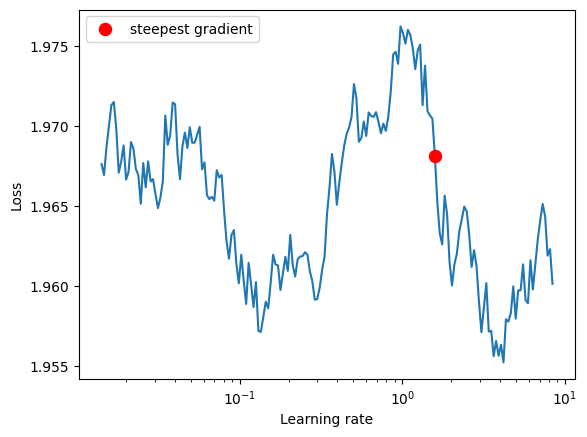

In [ ]:
from torch_lr_finder import LRFinder
from tqdm.autonotebook import tqdm

lr_finder = LRFinder(model_oclr, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
max_lr = 0.5
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=float(max_lr),
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS,
                                                pct_start=0.4,## how much percent of cycle to use for building up
                                                div_factor=10,## initial lr max/div_factor
                                                three_phase=False, ## no annihilation
                                                final_div_factor=100,## min lr max/div_factor
                                                anneal_strategy='linear'
                                                )

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm # for beautiful model training updates


def trainer(model,device, trainloader, testloader, optimizer,epochs,criterion,scheduler):
  train_losses = [] # to capture train losses over training epochs
  train_accuracy = [] # to capture train accuracy over training epochs
  test_losses = [] # to capture test losses
  test_accuracy = [] # to capture test accuracy
  for epoch in range(epochs):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, epoch,criterion,train_accuracy,train_losses,scheduler) # Training Function
    test(model, device, testloader,criterion,test_accuracy,test_losses)   # Test Function

  return train_accuracy, train_losses, test_accuracy, test_losses


# # Training Function
def train(model, device, train_loader, optimizer, epoch,criterion,train_accuracy,train_losses,scheduler = None):
  model.train() # setting the model in training
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = criterion(y_preds,labels) # capturing loss

    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    if scheduler:
      if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_accuracy.append(100*correct/processed)


# # Test Function
def test(model, device, test_loader,criterion,test_accuracy,test_losses) :
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector

      test_loss = criterion(outputs,labels).item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
 model = model.to(device)
 train_accuracy, train_losses, test_accuracy, test_losses = trainer(model = model,
                                                                    device = device,
                                                                    trainloader = train_loader,
                                                                    testloader = val_loader,
                                                                    optimizer = optimizer,
                                                                    epochs = EPOCHS,
                                                                    criterion = criterion,
                                                                    scheduler= scheduler)

EPOCH: 1


Loss=2.0003116130828857 Batch_id=119 Accuracy=17.85: 100%|██████████| 120/120 [00:12<00:00,  9.88it/s]



Test set: Average loss: 0.0047, Accuracy: 73/436 (16.74%)

EPOCH: 2


Loss=2.095550298690796 Batch_id=119 Accuracy=19.94: 100%|██████████| 120/120 [00:11<00:00, 10.80it/s]



Test set: Average loss: 0.0046, Accuracy: 73/436 (16.74%)

EPOCH: 3


Loss=1.8751440048217773 Batch_id=119 Accuracy=16.18: 100%|██████████| 120/120 [00:11<00:00, 10.60it/s]



Test set: Average loss: 0.0053, Accuracy: 73/436 (16.74%)

EPOCH: 4


Loss=1.8107537031173706 Batch_id=119 Accuracy=17.33: 100%|██████████| 120/120 [00:11<00:00, 10.16it/s]



Test set: Average loss: 0.0057, Accuracy: 77/436 (17.66%)

EPOCH: 5


Loss=1.758001685142517 Batch_id=119 Accuracy=17.95: 100%|██████████| 120/120 [00:11<00:00, 10.01it/s]



Test set: Average loss: 0.0038, Accuracy: 73/436 (16.74%)

EPOCH: 6


Loss=2.1353302001953125 Batch_id=119 Accuracy=17.75: 100%|██████████| 120/120 [00:12<00:00,  9.74it/s]



Test set: Average loss: 0.0040, Accuracy: 77/436 (17.66%)

EPOCH: 7


Loss=1.5665251016616821 Batch_id=119 Accuracy=18.68: 100%|██████████| 120/120 [00:12<00:00,  9.94it/s]



Test set: Average loss: 0.0050, Accuracy: 77/436 (17.66%)

EPOCH: 8


Loss=1.7911041975021362 Batch_id=119 Accuracy=19.52: 100%|██████████| 120/120 [00:12<00:00,  9.81it/s]



Test set: Average loss: 0.0041, Accuracy: 77/436 (17.66%)

EPOCH: 9


Loss=1.7803574800491333 Batch_id=119 Accuracy=17.54: 100%|██████████| 120/120 [00:12<00:00,  9.99it/s]



Test set: Average loss: 0.0041, Accuracy: 77/436 (17.66%)

EPOCH: 10


Loss=1.872428059577942 Batch_id=119 Accuracy=18.48: 100%|██████████| 120/120 [00:12<00:00,  9.88it/s]



Test set: Average loss: 0.0042, Accuracy: 73/436 (16.74%)

